In [16]:
!pip install --upgrade sympy

  Created wheel for mpmath: filename=mpmath-1.1.0-cp37-none-any.whl size=532244 sha256=a5f030630d69fec442120536720d22cce0cfa269c1251ebe5eb4d7431ca44766
  Stored in directory: C:\Users\vassi\AppData\Local\pip\Cache\wheels\63\9d\8e\37c3f6506ed3f152733a699e92d8e0c9f5e5f01dea262f80ad
Successfully built mpmath


In [71]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import pi, sin

In [72]:
def sq_triangle (A, f, tmin, tmax):
    """ Creates a square triangle function with amplitude A
    and frequency f in the time [tmin, tmax] """
    
    T = 1/f #period
    t0 = T/2

    periods = (tmax - tmin)/T #how many periods are in the [tmin, tmax]
    n = np.linspace(tmin, tmax, num = (int)(10000*periods)) #10000 samples per period
    
    e1 = lambda t : (4*t/T) - 1
    e2 = lambda t : -(4*t/T) + 3
    square = lambda e : (A*e)**2
    tri = map(lambda t : square(e1(t%T)) if (t%T<= t0) else square(e2(t%T)) , n)
    
    return n, list(tri)

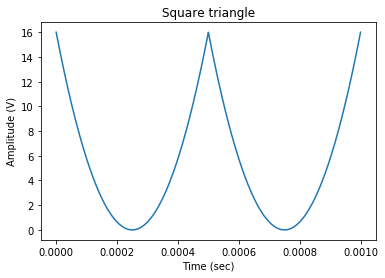

In [82]:
""" ΑΜ: 03115082 άρα 0+8+2=10 και 1+0=1 οπότε fm = 1 kHz"""
AM = 1

""" ΑΜ: 03115151 άρα 1+5+1=7 οπότε fm = 7 kHz """
#AM = 7

fm = AM*10**3 #Hz
A = 4 #Volt

Tm = 1/fm #sec

tmin, tmax = 0, Tm #1 period
n, tri = sq_triangle(A, fm, tmin, tmax)

plt.plot(n, tri)
plt.title('Square triangle')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (V)')
plt.show()

In [83]:
def sampling(signal, Ts, tmin, tmax):
    n = np.arange((int)(tmin / Ts), (tmax / Ts))
    y_out = map(lambda m : signal[(int)((len(signal)-1)*((m*Ts - tmin)/(tmax - tmin)))] , n)
    
    return n, list(y_out)

In [84]:
def find_q_level(levels, value):
    """ find the quantized value for each signal value """
    level = (np.abs(levels-value)).argmin()
    
    return levels[level]

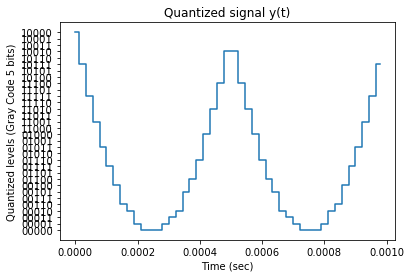

In [85]:
""" 2.a """
from sympy.combinatorics.graycode import GrayCode

fs1 = 45 * fm #Hz
Ts1 = 1.0 / fs1 #sec

# Signals sampled at fs1=45fm
n, y = sampling(tri, Ts1, tmin, tmax)

""" fm περιττή άρα κβάντιση με 5 bits """
bits = 5
levels = np.linspace(0, 16, 2**bits)

quantized_y = np.zeros(len(y))

time = 0
for t in n:
    quantized_y[time] = find_q_level(levels, y[time])
    time += 1
    
Gray = GrayCode(bits)
binaryLevels_Gray = list(Gray.generate_gray())

""" Gray κωδικοποίηση στον y άξονα """
plt.yticks(levels, binaryLevels_Gray)
plt.step(n*Ts1, quantized_y, where = 'mid')
plt.title('Quantized signal y(t)')
plt.xlabel('Time (sec)')
plt.ylabel('Quantized levels (Gray Code 5 bits)')
plt.show()

In [86]:
def calc_st_dev_and_snr(y, quantized_y, num_samples):
    """ Calculate the standard deviation """
    q_error = 0 #quantum error calculation
    for time in range(0, num_samples):                         
        q_error += (y[time] - quantized_y[time])

    m_q_error = (1./num_samples)*q_error #mean value of quantum error

    ss = 0
    for time in range(0, num_samples):
        q_error = y[time] - quantized_y[time]
        ss = ss + (q_error - m_q_error)**2 #ss = Σ(y - quantized_m_q_error)^2

    ss = ss/(num_samples - 1) ##ss =(ss / (num_samples-1)) fluctuation
    st_dev = np.sqrt(ss) #st_dev = sqrt(ss) standard deviation
    print("First", num_samples, "samples:")
    print("Standard deviation:", st_dev)
    
    """ Calculate the Signal Noise Ratio """
    p = 0
    for time in range(0, num_samples):
        p += quantized_y[time]**2 #p = Σ(quantized_y^2)

    p = 1.*(p/(num_samples)) #mean value

    snr = p/ss
    print ("Signal Noise Ratio:", snr)
    
    print()

In [87]:
""" 2.b """

""" (i) , (iii)"""
num_samples = 10 #first 10 samples
calc_st_dev_and_snr(y, quantized_y, num_samples) # calculate and print standard deviation and signal noise ratio

""" (ii) , (iii)"""
num_samples = 20 #first 20 samples
calc_st_dev_and_snr(y, quantized_y, num_samples) # calculate and print standard deviation and signal noise ratio

First 10 samples:
Standard deviation: 0.14497823419458597
Signal Noise Ratio: 3435.8997478252672

First 20 samples:
Standard deviation: 0.1487841805466669
Signal Noise Ratio: 1907.9601919337729



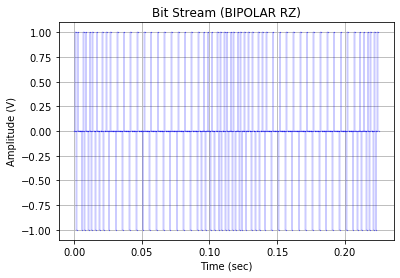

In [81]:
""" 3.b """

# 1 period
bit = np.zeros(len(quantized_y)*bits)

for i in range(0, len(quantized_y)):
    q = 5 + 5/(2**bits)
    q_level = y[i]//q
    temp = int(q_level+8)
    s = binaryLevels_Gray[temp]
    for j in range(0, bits):
        bit[bits*i + j] = s[j]
    
amplitude = np.zeros(len(bit)*2) #2 samples for each bit
A = fm/1000 #amplitude
positive_pulse = True
for i in range(0, len(bit)):
    # BIPOLAR RZ
    if (bit[i] == 0):
        amplitude[2*i] = 0.0
        amplitude[2*i+1] = 0.0
    elif (positive_pulse):
        amplitude[2*i] = A
        amplitude[2*i+1] = 0.0
        positive_pulse = False
    else:
        amplitude[2*i] = -A
        amplitude[2*i+1] = 0.0
        positive_pulse = True
        
# 1msec each bit => 0.5msec each sample
n = np.linspace(0, 0.0005*len(amplitude), len(amplitude))
plt.grid(True)
plt.step(n, amplitude, '-b.',markersize=0.4, linewidth=0.2)
plt.title('Bit Stream (BIPOLAR RZ)')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (V)')
plt.show()